<a href="https://colab.research.google.com/github/m3noob/Machine-Learning/blob/master/demo_sms_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo SMS Spam Detection

## Preparing resources

In [ ]:
!git clone https://github.com/huggingface/transformers
!pip install ./transformers/

### Download SMS Spam Bahasa Indonesia Dataset

Provided by Yudi Wibisono

[Other dataset can be access here](https://github.com/kmkurn/id-nlp-resource)

In [ ]:
!gdown --id 1-stKadfTgJLtYsHWqXhGO3nTjKVFxm_Q
!unzip -o /content/dataset_sms_spam_bhs_indonesia_v1.zip

### Exploring dataset

In [ ]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("dataset_sms_spam_v1.csv")
display_dataset = dataset.copy()

In [ ]:
display_dataset.head(10)

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2
5,5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket ...,2
6,"Ada iRing dgn tarif Rp. 0,1/7hr (perpanjangan ...",2
7,Akhir bulan harus tetap eksis loh! Internetan ...,2
8,Aktifkan iRing Coboy Jr - Terhebat. Tekan *808...,2
9,Ambil bonus harianmu di *600# (Bebas Pulsa). D...,2


In [ ]:
display_dataset.loc[display_dataset.label == 0, 'label'] = 'NORMAL'
display_dataset.loc[display_dataset.label == 1, 'label'] = 'FRAUD'
display_dataset.loc[display_dataset.label == 2, 'label'] = 'PROMO'

In [ ]:
display_dataset.head(100)

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,PROMO
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,PROMO
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",PROMO
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",PROMO
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,PROMO
...,...,...
95,Isi ulang Rp50000.0 berhasil. Kode transaksi 9...,PROMO
96,Jalani ibadah Haji dg nyaman tnpa prlu ganti k...,PROMO
97,"Jangan dikejar diskon berlari, beli RAWIT disk...",PROMO
98,JANGAN LUPA kirim 50 SMS sd 16 Juni 2013 utk m...,PROMO


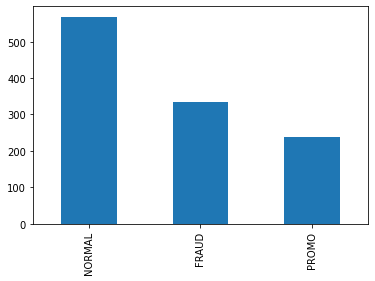

In [ ]:
_labels = display_dataset['label'].value_counts()
_labels.plot.bar()

### Split dataset into train, validation, and test split

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(dataset.Teks.to_list(), dataset.label.to_list(), shuffle=True, test_size=.2)
val_texts, test_texts, val_labels, test_labels = train_test_split(val_texts, val_labels, test_size=.5)

### Tokenize texts

In [ ]:
import torch
from torch import nn
from transformers import XLMRobertaTokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SpamDataset(train_encodings, train_labels)
val_dataset = SpamDataset(val_encodings, val_labels)
test_dataset = SpamDataset(test_encodings, test_labels)

In [ ]:
from typing import Dict
from sklearn.metrics import precision_recall_fscore_support
from transformers import EvalPrediction
def compute_metrics(p: EvalPrediction) -> Dict:
    preds = np.argmax(p.predictions, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids.flatten(), preds.flatten(), average='weighted', zero_division=0)
    return {
        'accuracy': (preds == p.label_ids).mean(),
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Get pretrained model and train it

In [ ]:
from torch.utils.data import DataLoader
from transformers import XLMRobertaForSequenceClassification, XLMRobertaConfig, AdamW, TrainingArguments, Trainer

config = XLMRobertaConfig.from_pretrained(
    'xlm-roberta-base',
    num_labels=3
)
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', config=config)
seed = 13

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,             # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,                # output log every #
    seed=seed,                       # random seed
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Step,Training Loss
10,1.109035
20,1.101979
30,1.081407
40,1.066504
50,0.993989
60,1.001661
70,0.954695
80,0.864605
90,0.776283
100,0.633852


TrainOutput(global_step=580, training_loss=0.30281656199488144)

## Evaluations

In [ ]:
# Evaluations
results = {}
result = trainer.evaluate()
for key, value in result.items():
  print("{} = {}".format(key, value))

eval_loss = 0.2219352275133133
eval_accuracy = 0.956140350877193
eval_f1 = 0.9564410821376765
eval_precision = 0.9587210780574624
eval_recall = 0.956140350877193
epoch = 10.0


## Test the model

In [ ]:
labels = ['NORMAL', 'FRAUD', 'PROMO']
is_spam = [
           'Kepoin suster Anya Geraldine di original series terbaru World of Dr. Boyke dg kode voucher BIMA dr Vidio utk km pelanggan Tri. Dptkan akses Vidio Premier Platinum 30 Hari dr 49rb, skrg hny 20rb! Cek di http://bimaplus.tri.co.id/Vidio',
           'PAKET SPESIAL YG LANGKA! Kuota 3GB 3hr Cuma Rp10rb. Balas HO untuk aktifkan. Nikmati kuota 1.5GB+1.5GB(01-09). AS203',
           'SHOPEE Slmt. NO.+6287878xxx Anda Resmi Men-daptkan Hadiah Ke-2 Cek Tunai Rp.175jt Kode ID Pemenang ;(AD25MD47) U/Info Hadiah Klik. www.super-shoppingday-99.com',
           'Selamat! SIM CARD Anda terpilih menjadi pemenang dari pesta ISI ULANG MOBOINDOSAT. Pin JK25FGR untuk info silakan kunjungi: www.juaramobo.cf',
           'Jaga jarak, hindari kerumunan. Aspirasi adalah hak, namunn tak lupa protokol kesehatan. #LindungiDiri #LindungiKeluarga covid19.go.id',
           'Apakah ini spam?',
           'Hanya kk&ktp sudah bisa buat modal usaha dengan bunga 0,2% Min 5-500jt Melayani Seluruh Indonesia Minat WA:081996947567',
           'fitria ,Minggu kmarin ketemu kaamu dijalan, kaamu sdh tidak kenal aku, coba lIhat fotoku chat-v.com/s/9dtu8y',
           'Sebagai nasabah Yth rek anda diNyatakan resmi mendpt hadiah dari berkah BRIpoin & Kode Cek Anda 02591234 Utk INFO klik:http://berkahpoinbri.blogspot.com'
]
encoded = tokenizer(is_spam,truncation=True, padding=True, return_tensors="pt")
encoded.to('cuda')
output = model(encoded['input_ids'], attention_mask=encoded['attention_mask'])
output_cpu = output[0].cpu()
output_indices = output_cpu.max(1).indices.tolist()

In [ ]:
for index in range(len(is_spam)):
  print(is_spam[index])
  print('Result = {}'.format(labels[output_indices[index]]))
  print('-'*20)


Kepoin suster Anya Geraldine di original series terbaru World of Dr. Boyke dg kode voucher BIMA dr Vidio utk km pelanggan Tri. Dptkan akses Vidio Premier Platinum 30 Hari dr 49rb, skrg hny 20rb! Cek di http://bimaplus.tri.co.id/Vidio
Result = PROMO
--------------------
PAKET SPESIAL YG LANGKA! Kuota 3GB 3hr Cuma Rp10rb. Balas HO untuk aktifkan. Nikmati kuota 1.5GB+1.5GB(01-09). AS203
Result = PROMO
--------------------
SHOPEE Slmt. NO.+6287878xxx Anda Resmi Men-daptkan Hadiah Ke-2 Cek Tunai Rp.175jt Kode ID Pemenang ;(AD25MD47) U/Info Hadiah Klik. www.super-shoppingday-99.com
Result = FRAUD
--------------------
Selamat! SIM CARD Anda terpilih menjadi pemenang dari pesta ISI ULANG MOBOINDOSAT. Pin JK25FGR untuk info silakan kunjungi: www.juaramobo.cf
Result = FRAUD
--------------------
Jaga jarak, hindari kerumunan. Aspirasi adalah hak, namunn tak lupa protokol kesehatan. #LindungiDiri #LindungiKeluarga covid19.go.id
Result = NORMAL
--------------------
Apakah ini spam?
Result = NORMAL


In [ ]:
tokenizer.tokenize(is_spam[5])

['▁Apakah', '▁ini', '▁spam', '?']